# Imports


In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys

sys.path.append("..")

import os
import matplotlib.pyplot as plt
import torch

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig

# Set config

In [20]:
llm_config = LLMConfig(
    vocab_size=512,
    context_size=256,
    dim_emb=512,
    num_layers=8,
    num_heads=8,
    emb_dropout=0.0,
    ffd_bias=True,
    ffd_dropout=0.0,
)

train_config = TrainingConfig(
    retrain_tokenizer=False, batch_size=64, learning_rate=1e-4, weight_decay=1e-2, max_steps=200, log_frequency=1
)

# Prepare tokenizer and dataset


In [16]:
input_file = "../data/shakespeare/alllines.txt"
output_path = "../data/shakespeare"

tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file) or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size, tokenizer_model_file)

tokenizer = Tokenizer(tokenizer_model_file)

In [17]:
sentence = "The role of the tokenizer is to build a mapping between a sentences represented as a string and token indices"
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁The', '▁r', 'o', 'le', '▁of', '▁the', '▁to', 'ke', 'n', 'i', 'z', 'er', '▁is', '▁to', '▁b', 'u', 'il', 'd', '▁a', '▁ma', 'pp', 'ing', '▁be', 't', 'w', 'e', 'en', '▁a', '▁', 's', 'ent', 'ence', 's', '▁re', 'p', 're', 's', 'ent', 'ed', '▁as', '▁a', '▁str', 'ing', '▁and', '▁to', 'ke', 'n', '▁in', 'd', 'ice', 's']


In [18]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.context_size, tokenizer)

ds_train.get_batch(batch_size=1)

(tensor([[159, 398, 220,  26,  26,  24, 383,  20,   6,   7,  31,  37,  44, 372,
          179,  14,  30,  15, 159,  33, 214,  89,  26,  24, 383,  20,   6,   7,
           31,  37,  44, 373,  67,  51,  35, 398, 220,  26,  26,   4,  84,  20,
            6,  37,  53,   7, 204,  89,  25,  73,  72,  42,  53, 344,   5,   4,
          113,  13,  18,  63,   9, 306,  20, 113, 160,   5, 341,  76, 177, 235,
           47,   5,   5,  41, 173,  18,  27,  76,  48, 110,   6,   7, 126,  17,
           30,  68,  14,  17,   5,  68,  14,   4,  12,  14, 330,   9, 122, 196,
           33, 437, 103,  33, 161,  27, 227,  18,   6,   5,  53,   5, 136,   6,
          104,   5,  77,  41,  33,  76, 268,  56, 490,   4,  73, 285,  64,  24,
           11, 208,  36,  48, 208, 123, 120,  83,   4, 259,  38, 103,  11, 150,
           34,  64,  10, 125,  62,  26, 344, 374,  42,  13,  61,  10, 186, 110,
            6,   5,  53,  86,  34,  64,  94,  21, 104,  95,   6,  36, 109,  49,
            8, 259,  10,  32, 132,   4, 

# Define model


In [22]:
model = LLM(
    vocab_size=llm_config.vocab_size,
    context_size=llm_config.context_size,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffd_bias=llm_config.ffd_bias,
    ffd_dropout=llm_config.ffd_dropout
)

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,d}")
print(f"model size: {size_all_mb:.3f}MB")

print(model)

total params: 17,327,104
learnable params: 17,327,104
model size: 67.098MB
LLM(
  (token_embedding): Embedding(512, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (positional_encoding): CosinePositionalEncoding()
        (proj_q): Linear(in_features=512, out_features=512, bias=False)
        (proj_k): Linear(in_features=512, out_features=512, bias=False)
        (proj_v): Linear(in_features=512, out_features=512, bias=False)
        (proj_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): SwiGLU(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
          (2): Linear(in_features=512, out_features=512, bias=True)
        )
 

# Train model


In [23]:
loss_history = train(
    model,
    ds_train,
    batch_size=train_config.batch_size,
    lr=train_config.learning_rate,
    max_steps=train_config.max_steps,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Text(0, 0.5, 'cross entropy loss')

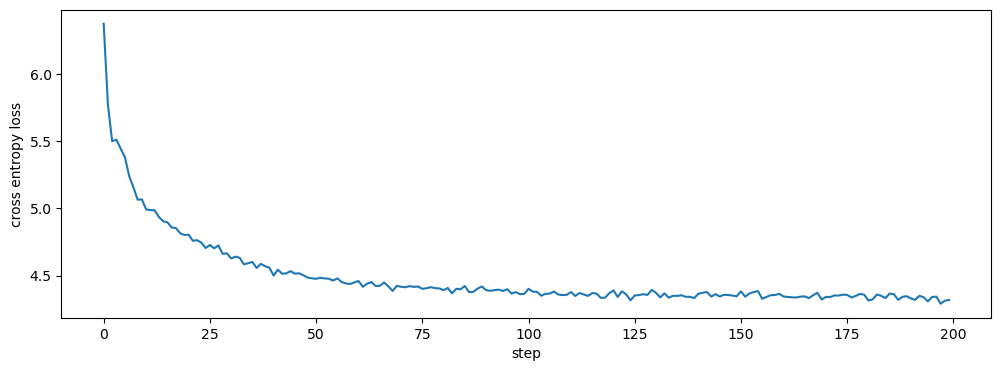

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")

# Play around

In [25]:
# empty prompt to generate random stuff
prompt = torch.zeros((1, llm_config.context_size), dtype=torch.int32)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

'ardet rid: but, and, And me this your be? or bred comes turn him we not show I compag have here, and are jus ch! HVogi made. some many.'

In [26]:
prompt = tokenizer.encode("I took an arrow to the knee, ", beg_of_string=True, pad_seq=True, seq_len=llm_config.context_size).view(1, -1)
out = model.generate(prompt, max_seq_len=50)
tokenizer.decode(out)

'I took an arrow to the knee, and, but thyng light is well. Why, I will titlesself do dishil, his bod greatself aight fal elseound ar to the world, with all to be no mores'